# Detect claims to fact check in political debates

In this project you will implement various classifiers using both neural and feature based technqiues to detect which sentences in political debates should be fact checked.
Dataset from ClaimBuster: https://zenodo.org/record/3609356 
Evaluate your classifiers using the same metrics as http://ranger.uta.edu/~cli/pubs/2017/claimbuster-kdd17-hassan.pdf (Table 2)

Classification report from sklearn provides everything

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import *

# Loading the data

In [2]:
df = pd.read_csv("../data_preprocessing/data_with_stop_words.csv")
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23533 entries, 0 to 23532
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       23533 non-null  int64         
 1   date        23533 non-null  datetime64[ns]
 2   Text        23533 non-null  object        
 3   Clean_text  23533 non-null  object        
 4   Verdict     23533 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 919.4+ KB


# Train-test split

In [3]:
mask = df["date"].dt.year < 2012

X_train = df.loc[mask, "Clean_text"].values
y_train = df.loc[mask, "Verdict"].values

X_test = df.loc[~mask, "Clean_text"].values
y_test = df.loc[~mask, "Verdict"].values

# Data Preprocessing

In [4]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## One hot encoding representation

The `Tokenizer` converts a text corpus into a list of integers. This class maps each word, and encodes the corpus. The map assigns an integer to every word and creates a dictionary, where the keys are the vocabulary terms themselves. Some parameters such as `num_words` set the maximum size of the vocabulary using the most comon words.

In [5]:
vocabulary_size = 5000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)

Encodding Test data

In [6]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)

In [7]:
word_index = tokenizer.word_index # same as vocabulary

## Padding sequences

In [8]:
max_length = 100
X_train_embedded=pad_sequences(X_train_encoded,padding='post',maxlen=max_length, truncating='post')
print(X_train_embedded)

[[  45   16   13 ...    0    0    0]
 [  44   93   22 ...    0    0    0]
 [   1  583 2982 ...    0    0    0]
 ...
 [   3    4   27 ...    0    0    0]
 [ 389 1378    5 ...    0    0    0]
 [   3  389   46 ...    0    0    0]]


### For training

In [9]:
X_train_embedded.shape

(18170, 100)

### For testing

In [10]:
X_test_embedded=pad_sequences(X_test_encoded,padding='post',maxlen=max_length)
print(X_test_embedded.shape)

(5363, 100)


### For the labels

In [11]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train.reshape(-1, 1))
y_encoded = one_hot_encoder.transform(y_train.reshape(-1, 1))

y_encoded.shape

(18170, 3)

In [12]:
y_encoded_test = one_hot_encoder.transform(y_test.reshape(-1,1))
y_encoded_test.shape

(5363, 3)

# Creating the model

### Importing the pretrained weights for the embedding matrix

The pretrained weights used in this report are from the  <strong> Global Vectors for Word Representation </strong> `GloVe` model. Wich can be downloaded from https://nlp.stanford.edu/projects/glove/.

We chose the first option [glove.6B.zip](https://nlp.stanford.edu/data/glove.6B.zip), which contais Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download). This option contains 4 `.txt` files. We use the `glove.6B.100d.txt` as our sequences were padded to have `max_len =100`

Once the zip file is downloaded, place the zip into the data folder and run the following code:

```import os
import zipfile
with zipfile.ZipFile('../data/glove.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/glove')
```


In [13]:
# import os
# import zipfile
# with zipfile.ZipFile('../data/glove.zip', 'r') as zip_ref:
#     zip_ref.extractall('../data/glove')

In [14]:
embeddings_index = {}
f = open('../data/glove/glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Defining plotting functions

- confusion matrix

In [16]:
def plot_model_history(model_history):
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(model_history.history['loss'], label='train')
    plt.plot(model_history.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(model_history.history['accuracy'], label='train')
    plt.plot(model_history.history['val_accuracy'], label='test')
    plt.legend()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [17]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    Plot the confusion matrix.
    Normalization is applied by setting `normalize=True`.

    Code soure: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Bidirectional LSTM 

In [18]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

callback =  EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=None,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [19]:
embedding_dim = 100
model_bi = Sequential()
model_bi.add(Embedding(len(word_index) + 1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_bi.add(Bidirectional(LSTM(100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(97, activation = "relu"))
model_bi.add(Dense(3, activation='softmax'))
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1035300   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 97)                19497     
                                                                 
 dense_1 (Dense)             (None, 3)                 294       
                                                                 
Total params: 1,215,891
Trainable params: 180,591
Non-trainable params: 1,035,300
________________________________________

In [20]:
model_bi.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10
                #, callbacks=[callback]
                )

Epoch 1/10
455/455 [==============================] - 31s 63ms/step - loss: 0.6315 - accuracy: 0.7524 - val_loss: 0.6167 - val_accuracy: 0.7510
Epoch 2/10
455/455 [==============================] - 27s 60ms/step - loss: 0.5550 - accuracy: 0.7853 - val_loss: 0.5917 - val_accuracy: 0.7562
Epoch 3/10
455/455 [==============================] - 28s 61ms/step - loss: 0.5315 - accuracy: 0.7912 - val_loss: 0.5984 - val_accuracy: 0.7567
Epoch 4/10
455/455 [==============================] - 30s 66ms/step - loss: 0.5130 - accuracy: 0.7988 - val_loss: 0.6388 - val_accuracy: 0.7501
Epoch 5/10
455/455 [==============================] - 25s 54ms/step - loss: 0.5033 - accuracy: 0.8023 - val_loss: 0.5667 - val_accuracy: 0.7669
Epoch 6/10
455/455 [==============================] - 26s 57ms/step - loss: 0.4872 - accuracy: 0.8096 - val_loss: 0.6060 - val_accuracy: 0.7620
Epoch 7/10
455/455 [==============================] - 28s 61ms/step - loss: 0.4696 - accuracy: 0.8163 - val_loss: 0.5752 - val_accuracy:

In [21]:
predictions = model_bi.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.77      0.93      0.84      3314
         UFS       0.47      0.37      0.41       623
         CFS       0.74      0.46      0.57      1426

    accuracy                           0.74      5363
   macro avg       0.66      0.59      0.61      5363
weighted avg       0.73      0.74      0.72      5363



Confusion matrix, without normalization


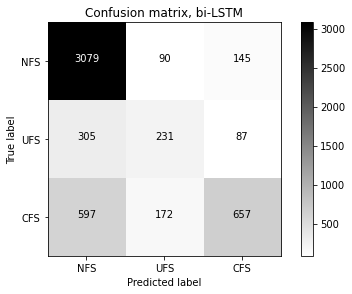

In [22]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"], title='Confusion matrix, bi-LSTM')

## Stacked Bi-LSTM

In [23]:
clear_session()

In [24]:
model_Sbi = Sequential()
model_Sbi.add(Embedding(len(word_index) + 1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_Sbi.add(Dropout(0.2))
model_Sbi.add(Bidirectional(LSTM(100, return_sequences=True)))
model_Sbi.add(Bidirectional(LSTM(100)))
model_Sbi.add(Dropout(0.2))
model_Sbi.add(Dense(97, activation = "relu"))
model_Sbi.add(Dense(3, activation='softmax'))
model_Sbi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Sbi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1035300   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 200)         160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 97)                1

In [25]:
model_Sbi.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10
                #, callbacks=[callback]
                )

Epoch 1/10
455/455 [==============================] - 71s 147ms/step - loss: 0.6267 - accuracy: 0.7517 - val_loss: 0.6941 - val_accuracy: 0.7364
Epoch 2/10
455/455 [==============================] - 52s 115ms/step - loss: 0.5659 - accuracy: 0.7770 - val_loss: 0.6602 - val_accuracy: 0.7543
Epoch 3/10
455/455 [==============================] - 53s 116ms/step - loss: 0.5423 - accuracy: 0.7882 - val_loss: 0.5737 - val_accuracy: 0.7603
Epoch 4/10
455/455 [==============================] - 54s 119ms/step - loss: 0.5174 - accuracy: 0.7962 - val_loss: 0.5660 - val_accuracy: 0.7661
Epoch 5/10
455/455 [==============================] - 55s 120ms/step - loss: 0.5012 - accuracy: 0.8036 - val_loss: 0.5884 - val_accuracy: 0.7609
Epoch 6/10
455/455 [==============================] - 55s 120ms/step - loss: 0.4806 - accuracy: 0.8143 - val_loss: 0.5795 - val_accuracy: 0.7716
Epoch 7/10
455/455 [==============================] - 56s 124ms/step - loss: 0.4649 - accuracy: 0.8171 - val_loss: 0.5699 - val_ac

In [26]:
predictions = model_Sbi.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.78      0.92      0.84      3314
         UFS       0.51      0.33      0.40       623
         CFS       0.71      0.51      0.59      1426

    accuracy                           0.74      5363
   macro avg       0.67      0.59      0.61      5363
weighted avg       0.73      0.74      0.73      5363



Confusion matrix, without normalization


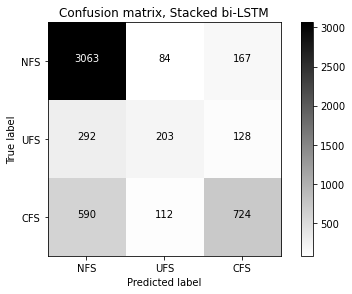

In [27]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"], title='Confusion matrix, Stacked bi-LSTM')

## Convolutional Neural Network

In [28]:
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D
clear_session()


In [29]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(len(word_index) + 1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model.add(Conv1D(128, 10, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1035300   
                                                                 
 conv1d (Conv1D)             (None, 91, 128)           128128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,167,655
Trainable params: 132,355
Non-trainable params: 1,035,300
________________________________________

In [30]:
model.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10
                #, callbacks=[callback]
                )

Epoch 1/10
455/455 [==============================] - 5s 11ms/step - loss: 0.6130 - accuracy: 0.7567 - val_loss: 0.5964 - val_accuracy: 0.7488
Epoch 2/10
455/455 [==============================] - 5s 11ms/step - loss: 0.4938 - accuracy: 0.8059 - val_loss: 0.6123 - val_accuracy: 0.7515
Epoch 3/10
455/455 [==============================] - 5s 11ms/step - loss: 0.4090 - accuracy: 0.8413 - val_loss: 0.5975 - val_accuracy: 0.7534
Epoch 4/10
455/455 [==============================] - 5s 10ms/step - loss: 0.3262 - accuracy: 0.8751 - val_loss: 0.6804 - val_accuracy: 0.7512
Epoch 5/10
455/455 [==============================] - 5s 11ms/step - loss: 0.2181 - accuracy: 0.9225 - val_loss: 0.7505 - val_accuracy: 0.7389
Epoch 6/10
455/455 [==============================] - 5s 11ms/step - loss: 0.1360 - accuracy: 0.9549 - val_loss: 0.9213 - val_accuracy: 0.7485
Epoch 7/10
455/455 [==============================] - 5s 11ms/step - loss: 0.0850 - accuracy: 0.9751 - val_loss: 0.9466 - val_accuracy: 0.7386

In [31]:
predictions = model.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))

              precision    recall  f1-score   support

         NFS       0.76      0.90      0.83      3314
         UFS       0.39      0.36      0.37       623
         CFS       0.69      0.43      0.53      1426

    accuracy                           0.71      5363
   macro avg       0.62      0.56      0.58      5363
weighted avg       0.70      0.71      0.69      5363



Confusion matrix, without normalization


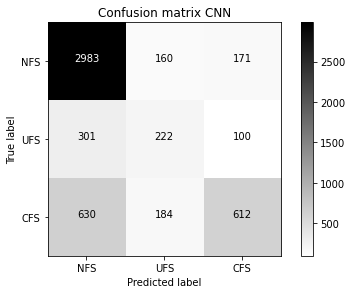

In [32]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"], title='Confusion matrix CNN')

## Convolutional Neural network + LSTM

In [33]:
model_conv = Sequential()
model_conv.add(Embedding(len(word_index) + 1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(128, 10, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=10))
model_conv.add(LSTM(100))
model_conv.add(Dense(32, activation = "relu"))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1035300   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 91, 128)           128128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 128)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense_2 (Dense)             (None, 32)                3232      
                                                      

In [35]:
model_conv.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10
                #, callbacks=[callback]
                )

Epoch 1/10
455/455 [==============================] - 9s 17ms/step - loss: 0.6825 - accuracy: 0.7323 - val_loss: 0.6475 - val_accuracy: 0.7474
Epoch 2/10
455/455 [==============================] - 7s 16ms/step - loss: 0.5750 - accuracy: 0.7735 - val_loss: 0.6203 - val_accuracy: 0.7455
Epoch 3/10
455/455 [==============================] - 8s 17ms/step - loss: 0.5292 - accuracy: 0.7940 - val_loss: 0.5892 - val_accuracy: 0.7614
Epoch 4/10
455/455 [==============================] - 8s 17ms/step - loss: 0.4923 - accuracy: 0.8074 - val_loss: 0.5994 - val_accuracy: 0.7606
Epoch 5/10
455/455 [==============================] - 7s 16ms/step - loss: 0.4406 - accuracy: 0.8301 - val_loss: 0.6378 - val_accuracy: 0.7587
Epoch 6/10
455/455 [==============================] - 7s 16ms/step - loss: 0.4063 - accuracy: 0.8467 - val_loss: 0.6125 - val_accuracy: 0.7576
Epoch 7/10
455/455 [==============================] - 7s 16ms/step - loss: 0.3606 - accuracy: 0.8658 - val_loss: 0.7616 - val_accuracy: 0.7507

In [36]:
predictions = model_conv.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.73      0.95      0.83      3314
         UFS       0.46      0.21      0.29       623
         CFS       0.72      0.40      0.52      1426

    accuracy                           0.72      5363
   macro avg       0.64      0.52      0.54      5363
weighted avg       0.70      0.72      0.68      5363



Confusion matrix, without normalization


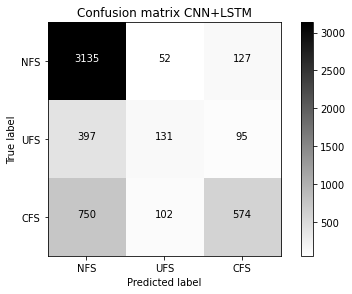

In [37]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"], title='Confusion matrix CNN+LSTM')

## Hyper parameter tunning - Bidirectional LSTM

In [51]:
def build_model(unit,drop_out,dense):
    embedding_dim = 100
    model_bi = Sequential()
    model_bi.add(Embedding(len(word_index) + 1, 
                            output_dim=max_length, 
                            input_length=max_length,
                            weights=[embedding_matrix],
                            trainable = False
                            ))
    model_bi.add(Bidirectional(LSTM(unit)))
    model_bi.add(Dropout(drop_out))
    model_bi.add(Dense(dense, activation = "relu"))
    model_bi.add(Dense(3, activation='softmax'))
    model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_bi

In [50]:
clear_session()

In [53]:
unit = [300, 350]
drop_out = [0.6, 0.65, 0.7]
dense = [32, 100, 250]
scores = {}
i = 0
for u in unit:
    for drop in drop_out:
        for den in dense:
            model = build_model(u, drop, den)
            model.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 5, verbose=0)
            y_predict = model.predict(X_test_embedded)
            y_preds = one_hot_encoder.inverse_transform(y_predict).reshape(-1,)
            if i == 0:
                F1 = f1_score(y_test, y_preds, average='weighted')

                scores.update({ 
                            'f1':  F1,
                            'unit': u,
                            'drop_out': drop,
                            'dense': den})
            else:
                
                F1 = f1_score(y_test, y_preds, average='weighted')

                if F1 > scores['f1']: 

                    scores.update({ 
                                'f1':  F1,
                                'unit': u,
                                'drop_out': drop,
                                'dense': den})
            i+=1
            print(f'unit: {u}, drop_out: {drop}, dense: {den}, f1: {F1}')
            clear_session()


unit: 300, drop_out: 0.6, dense: 32, f1: 0.6779642791962793
unit: 300, drop_out: 0.6, dense: 100, f1: 0.686774385278598
unit: 300, drop_out: 0.6, dense: 250, f1: 0.7022333044878466
unit: 300, drop_out: 0.65, dense: 32, f1: 0.6882708451271887
unit: 300, drop_out: 0.65, dense: 100, f1: 0.6967097479266691
unit: 300, drop_out: 0.65, dense: 250, f1: 0.7183413248093649
unit: 300, drop_out: 0.7, dense: 32, f1: 0.7188720883120961
unit: 300, drop_out: 0.7, dense: 100, f1: 0.7255109453578212
unit: 300, drop_out: 0.7, dense: 250, f1: 0.7119875640995232
unit: 350, drop_out: 0.6, dense: 32, f1: 0.7178446710994056
unit: 350, drop_out: 0.6, dense: 100, f1: 0.714997032779185
unit: 350, drop_out: 0.6, dense: 250, f1: 0.6882557288432918
unit: 350, drop_out: 0.65, dense: 32, f1: 0.7190820826254531
unit: 350, drop_out: 0.65, dense: 100, f1: 0.7267048366494475
unit: 350, drop_out: 0.65, dense: 250, f1: 0.71070432429615
unit: 350, drop_out: 0.7, dense: 32, f1: 0.7209737056031045
unit: 350, drop_out: 0.7, de

In [54]:
scores

{'f1': 0.7267048366494475, 'unit': 350, 'drop_out': 0.65, 'dense': 100}

In [ ]:
embedding_dim = 100
model_bi = Sequential()
model_bi.add(Embedding(len(word_index) + 1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_bi.add(Bidirectional(LSTM(350)))
model_bi.add(Dropout(0.65))
model_bi.add(Dense(100, activation = "relu"))
model_bi.add(Dense(3, activation='softmax'))
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi.summary()
model_bi.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10
                #, callbacks=[callback]
                )


In [57]:
predictions = model_bi.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))

              precision    recall  f1-score   support

         NFS       0.80      0.91      0.85      3314
         UFS       0.51      0.34      0.41       623
         CFS       0.70      0.57      0.63      1426

    accuracy                           0.75      5363
   macro avg       0.67      0.61      0.63      5363
weighted avg       0.74      0.75      0.74      5363



Confusion matrix, without normalization


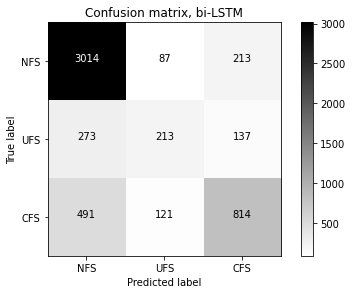

In [58]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"], title='Confusion matrix, bi-LSTM')

We can see that fine tuning the Bi-LSTM model resulted in higher performance of the classifier. The proportion of samples correctly classified for the CFS class also increased in comparison with the original case.

### ROC curve

The ROC curve implementation waas retrived from https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

C:\Users\bruna\AppData\Local\Temp/ipykernel_15908/2509742168.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


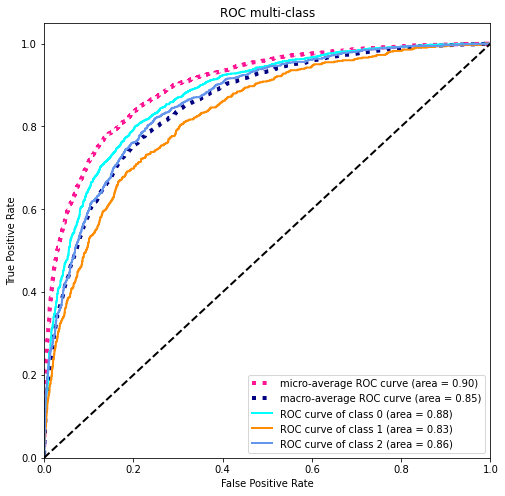

In [61]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc



# Plot linewidth.
lw = 2

n_classes = 3

#Plotting

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_encoded_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_encoded_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC multi-class')
plt.legend(loc="lower right")
plt.show()
